# **Prepare for environment**

Colab

In [1]:
# !git clone https://github.com/ycc789741ycc/anime-recommender-system.git
# %cd /content/anime-recommender-system/
# !gdown --id 1sIT71hnPdT8rPbqm3j9q_yjkRE-cCjjM
# !mkdir data
# !mkdir model
# !mv animelist.csv.zip ./data
# !unzip ./data/animelist.csv.zip
# !mv animelist.csv ./data

Cloning into 'anime-recommender-system'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 90 (delta 39), reused 75 (delta 24), pack-reused 0
Unpacking objects: 100% (90/90), done.
/content/anime-recommender-system
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1sIT71hnPdT8rPbqm3j9q_yjkRE-cCjjM
To: /content/anime-recommender-system/animelist.csv.zip
100% 475M/475M [00:05<00:00, 88.2MB/s]
Archive:  ./data/animelist.csv.zip
  inflating: animelist.csv           


local

In [1]:
%cd ..

/mnt/c/Users/Yoshi/source/repos/Sideprojects/Anime_Recommender_system


# **Logger setting**

In [2]:
import logging

logger = logging.getLogger()

chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)

logger.addHandler(chandler)
logger.setLevel(logging.INFO)


# **Load Data (If have the preprocessed data then can skip.)**

In [3]:
INPUT_DIR = './data'
!ls {INPUT_DIR}

animelist.csv  animelist.csv.zip


In [4]:
import numpy as np
import pandas as pd

rating_df_iter = pd.read_csv(INPUT_DIR + '/animelist.csv', 
                        low_memory=False, 
                        engine='c',
                        usecols=["user_id", "anime_id", "rating"],
                        chunksize=10000
                        )

rating_df = pd.concat(rating_df_iter)

# rating_df = pd.read_csv(INPUT_DIR + '/animelist_min.csv', 
#                         low_memory=False, 
#                         usecols=["user_id", "anime_id", "rating"]
#                         )

rating_df.head(4)

NumExpr defaulting to 2 threads.


,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0


In [5]:
# User should rate atleast 400 animies
n_user_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_user_ratings[n_user_ratings >= 2000].index)].copy(deep=False)
n_anime_ratings = rating_df['anime_id'].value_counts()
rating_df = rating_df[rating_df['anime_id'].isin(n_anime_ratings[n_anime_ratings >= 50].index)].copy(deep=False)
len(rating_df)

7576716

In [6]:
# Scaling BTW (0 , 1.0)
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])
print('Avg', AvgRating)

Avg 0.313771546934054


In [7]:
# Removing Duplicated Rows
duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating_df = rating_df[~duplicates]

print('> {} duplicates'.format(rating_df.duplicated().sum()))

> 0 duplicates


## **Data Preprocessing (If have the preprocessed data then can skip.)**

In [8]:
# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

field_dims = [n_users, n_animes]

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 2463, Num of animes: 15749
Min rating: 0.0, Max rating: 1.0


In [9]:
# Shuffle
rating_df = rating_df.sample(frac=1, random_state=73).copy(deep=False)

df_x = rating_df[['user', 'anime']].copy(deep=False)
df_y = rating_df[["rating"]].copy(deep=False)

Save the preprocessed data

In [10]:
compression_opts = dict(method='zip', archive_name='preprocessed_animelist.csv')  
rating_df.to_csv('preprocessed_animelist.csv.zip', index=False, compression=compression_opts)

export the encode config

In [11]:
import json


encode_config = {
    'user2user_encoded': user2user_encoded,
    'user_encoded2user': user_encoded2user,
    'anime2anime_encoded': anime2anime_encoded,
    'anime_encoded2anime': anime_encoded2anime
}

with open('./model/encode_config.json', 'w') as f:
    json.dump(encode_config, f, indent=4, ensure_ascii=False)

# **Load data from preprocessed dataset.(If have preprocessed dataset can start from here)**

Colab

In [ ]:
# !gdown --id 1CLWxXspLAP_7FQjAdU4I2cBpWQiiAgvk
# !mv preprocessed_animelist.csv.zip ./data

Unzip data

In [ ]:
# !unzip ./data/preprocessed_animelist.csv.zip
# !mv preprocessed_animelist.csv ./data

For local

In [1]:
%cd ..

/mnt/c/Users/Yoshi/source/repos/Sideprojects/Anime_Recommender_system


In [2]:
INPUT_DIR = './data'
!ls {INPUT_DIR}

import numpy as np
import pandas as pd

# rating_df_iter = pd.read_csv(INPUT_DIR + '/preprocessed_animelist.csv', 
#                         low_memory=False, 
#                         usecols=["user_id", "anime_id", "rating"],
#                         chunksize=10000
#                         )

# rating_df = pd.concat(rating_df_iter)

rating_df = pd.read_csv(INPUT_DIR + '/preprocessed_animelist.csv', 
                        low_memory=False, 
                        usecols=["user_id", "anime_id", "rating"]
                        )

rating_df.head(4)

anime_with_synopsis.csv      animelist_min.csv
anime_with_synopsis.csv.zip  preprocessed_animelist.csv


,user_id,anime_id,rating
0,278536,31845,0.9
1,56255,24919,0.0
2,54171,2386,0.6
3,292408,5028,0.7


In [3]:
# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

field_dims = [n_users, n_animes]

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 2463, Num of animes: 15749
Min rating: 0.0, Max rating: 1.0


pairwise rating

In [4]:
rating_df["rating"] = rating_df["rating"].transform(lambda x: 1.0 if x > 0.6 else 0.)

In [5]:
df_x = rating_df[['user', 'anime']].copy(deep=False)
df_y = rating_df[["rating"]].copy(deep=False)

encode config

In [6]:
import json


encode_config = {
    'user2user_encoded': user2user_encoded,
    'user_encoded2user': user_encoded2user,
    'anime2anime_encoded': anime2anime_encoded,
    'anime_encoded2anime': anime_encoded2anime
}

with open('./model/encode_config.json', 'w') as f:
    json.dump(encode_config, f, indent=4, ensure_ascii=False)

# **Training config**

In [7]:
import os
from recanime.schema.training import TrainingConfig

training_config = TrainingConfig(
    batch_size=2048,
    epochs=5,
    n_workers=os.cpu_count(),
    model_size=1000,
    lr_factor=2.,
    lr_warm_up=2000
)

# **Load data into tensor**

In [8]:
import torch


from recanime.training.functools import get_dataloader, get_dataloader_df
from recanime.training.dataset import MyDataSet


# dataset = MyDataSet(df_x=df_x, df_y=df_y)
# train_loader, valid_loader, test_loader = get_dataloader(
#     dataset=dataset,
#     batch_size=training_config.batch_size,
#     n_workers=training_config.n_workers,
#     valid_ratio=0.1,
#     test_ratio=0.1
# )

train_loader, valid_loader, test_loader = get_dataloader_df(
    df_x=df_x,
    df_y=df_y,
    batch_size=training_config.batch_size,
    n_workers=training_config.n_workers,
    valid_ratio=0.1,
    test_ratio=0.1
)

/home/yoshi/miniconda3/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Import the model**

In [9]:
from recanime.recommender.ranking_base_filter.model import FactorizationMachineModel

model = FactorizationMachineModel(
    field_dims=field_dims,
    embed_dim=32
)

# **Train the model** 

optimizer

In [10]:
from recanime.training.trainer import NoamOpt

# optimizer = NoamOpt(
#     **training_config.get_optimizer_config(),
#     optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)
# )

optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

loss criterion

In [11]:
import torch.nn as nn

# loss_criterion = nn.MSELoss()
loss_criterion = nn.BCELoss()

Load previous training status and model

In [12]:
# from recanime.schema.training import TrainingStatus

# INPUT_DIR = './recanime/model'

# with open(INPUT_DIR + "/training_status.json", 'r') as f:
#     training_status_dict = json.load(f)
#     training_status = TrainingStatus(**training_status_dict)
    
# model = torch.load(INPUT_DIR + "/model.pt")

In [13]:
from recanime.training.trainer import ModelTrainer

INPUT_DIR = './recanime/model'

cuda = torch.cuda.is_available()  
device = torch.device('cuda' if cuda else 'cpu')

model_trainer = ModelTrainer(
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    loss_criterion=loss_criterion,
    optimizer=optimizer,
    device=device,
    model_save_path=INPUT_DIR + "/model.pt",
    #training_status=training_status
)

Start to train

In [14]:
for epoch in range(training_config.epochs):
    training_status = model_trainer.training_one_epoch()

train epoch 4:   0%|          | 0/2959 [00:00<?, ?it/s]/home/yoshi/miniconda3/envs/ml/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/home/yoshi/miniconda3/envs/ml/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
validation epoch 8: 100%|██████████| 369/369 [00:51<00:00,  7.19it/s]


plot the training history

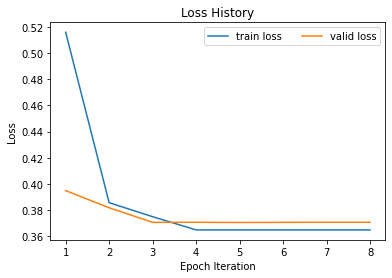

In [15]:
from recanime.training.functools import training_loss_epoch_mean_visualization


training_status = model_trainer.export_training_status()
train_epoch_x = list(training_status.train_loss_epoch_mean.keys())
train_loss_y = list(training_status.train_loss_epoch_mean.values())
valid_epoch_x = list(training_status.valid_loss_epoch_mean.keys())
valid_loss_y = list(training_status.valid_loss_epoch_mean.values())

training_loss_epoch_mean_visualization(
    epoch_x=train_epoch_x,
    train_loss_y=train_loss_y,
    valid_loss_y=valid_loss_y
)

Save training status

In [16]:
loss = model_trainer.test(test_loader)
print(f"Testing loss: {loss}")

test epoch 8: 100%|██████████| 369/369 [00:53<00:00,  6.93it/s]

Testing loss: 0.37136956225565776


In [17]:
import json


with open("./model/training_status.json", 'w') as f:
    json.dump(training_status.dict(), f, indent=4, ensure_ascii=False)